## Scraping Box Office Mojo

In [3]:
from bs4 import BeautifulSoup as bs
import requests
import re
import csv
import re
import imdb
ia = imdb.IMDb()
import pandas as pd


In [133]:
# Necessary imports
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
from sklearn.model_selection import train_test_split

In [534]:
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

In [535]:
import dateutil.parser

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    if type(runtimestring) == str:
        runtime = runtimestring.split()
        try:
            minutes = int(runtime[0])*60 + int(runtime[2])
            return minutes
        except:
            return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [538]:
url = 'https://www.boxofficemojo.com/year/'

response = requests.get(url)
page = response.text

soup = BeautifulSoup(page,"lxml")

In [539]:
table = soup.find('table')


In [540]:
rows = [row for row in table.find_all('tr')]

In [555]:
years = {}

for num in range(2,10):
    years[(rows[num].find_all('td')[0].find('a')['href'])[6:10]] = (rows[num].find_all('td')[0].find('a')['href']) 
    

In [556]:
years

{'2019': '/year/2019/?ref_=bo_yl_table_2',
 '2018': '/year/2018/?ref_=bo_yl_table_3',
 '2017': '/year/2017/?ref_=bo_yl_table_4',
 '2016': '/year/2016/?ref_=bo_yl_table_5',
 '2015': '/year/2015/?ref_=bo_yl_table_6',
 '2014': '/year/2014/?ref_=bo_yl_table_7',
 '2013': '/year/2013/?ref_=bo_yl_table_8',
 '2012': '/year/2012/?ref_=bo_yl_table_9'}

In [557]:
for key in years:
    years[key] = 'https://www.boxofficemojo.com' + years[key]

In [558]:
#we have a dict full of years with their links! 
years

{'2019': 'https://www.boxofficemojo.com/year/2019/?ref_=bo_yl_table_2',
 '2018': 'https://www.boxofficemojo.com/year/2018/?ref_=bo_yl_table_3',
 '2017': 'https://www.boxofficemojo.com/year/2017/?ref_=bo_yl_table_4',
 '2016': 'https://www.boxofficemojo.com/year/2016/?ref_=bo_yl_table_5',
 '2015': 'https://www.boxofficemojo.com/year/2015/?ref_=bo_yl_table_6',
 '2014': 'https://www.boxofficemojo.com/year/2014/?ref_=bo_yl_table_7',
 '2013': 'https://www.boxofficemojo.com/year/2013/?ref_=bo_yl_table_8',
 '2012': 'https://www.boxofficemojo.com/year/2012/?ref_=bo_yl_table_9'}

In [562]:
def movie_list(val):
    movies = {}
    

    url = val
    response = requests.get(url)
    page = response.text

    soup = BeautifulSoup(page,"lxml")

    table = soup.find('table')
    rows = [row for row in table.find_all('tr')]
    for row in rows[1:276]:
        items = row.find_all('td')
        link = items[1].find('a')
        title, url = link.text, link['href']
        movies[title] = [url]
    
    return movies


In [563]:
movie_urls = {}

In [564]:

for key in years:
    movie_urls.update(movie_list(years[key]))
    print(f"{key} is done!")


2019 is done!
2018 is done!
2017 is done!
2016 is done!
2015 is done!
2014 is done!
2013 is done!
2012 is done!


In [565]:
len(movie_urls)

1959

In [566]:
def get_movie_dict(link):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
        - title 
        - domestic gross
        - runtime 
        - MPAA rating
        - full release date
    Return information as a dictionary.
    '''
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    proper = ''.join(link)
    url = base_url + proper
    
    
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title', 'domestic_total_gross',
               'runtime_minutes', 'rating', 'release_date','genres',
              'days_in_release','theaters','month','budget', 'opening']
    
    #Get title
    title_string = soup.find('title').text
    title = title_string.split('-')[0].strip()

    #Get domestic gross
    raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    domestic_total_gross = money_to_int(raw_domestic_total_gross)

    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    if type(raw_runtime) == str:
        runtime = runtime_to_minutes(raw_runtime)
    else:
        runtime = raw_runtime 
        
    
    #Get rating
    rating = get_movie_value(soup,'MPAA')

    #Get release date
    raw_release_date = get_movie_value(soup,'Release Date')
    if type(raw_release_date) == str:
        raw_release_date = raw_release_date.split('\n')[0]
    
    genres = get_movie_value(soup, 'Genres')
    if type(genres) == str:
        genres = genres.split()
    
    in_release = get_movie_value(soup, 'In Release')
    if type(in_release) == str:
        in_release = in_release.split('/')
        in_release.pop(1)
        in_release = str(in_release)
        in_release = (re.findall('\d+', in_release))
        days_in_release = int(''.join(in_release))
    
    theaters = get_movie_value(soup,'Widest Release')
    if type(theaters) == str:
        theaters = str(theaters.split())
        theaters = (re.findall('\d+', theaters))
        theaters = int(''.join(theaters))
    
    month = ''
    
    if type(raw_release_date) == str:
        month = raw_release_date.split()
        month = month[0]
    
    budget = get_movie_value(soup,'Budget')
    if type(budget) == str:
        budget = budget.replace('$','')
        budget = budget.replace(',','')
        budget = int(budget)
    
    opening = get_movie_value(soup,'Distributor')
    if type(opening) == str:
        opening = opening.split('See')
        opening = opening.pop(0)
    
    
    #Create movie dictionary and return
    movie_dict = dict(zip(headers, [title,
                                domestic_total_gross,
                                runtime,
                                rating, 
                                raw_release_date,genres, days_in_release,
                                   theaters, month, budget, opening]))

    return movie_dict

In [567]:
movie_lists = []

for link in movie_urls:
    movie_lists.append(get_movie_dict(movie_urls[link]))
    print(f'{link} is done!')

Avengers: Endgame is done!
The Lion King is done!
Toy Story 4 is done!
Frozen II is done!
Captain Marvel is done!
Star Wars: Episode IX - The Rise of Skywalker is done!
Spider-Man: Far from Home is done!
Aladdin is done!
Joker is done!
It Chapter Two is done!
Jumanji: The Next Level is done!
Us is done!
Fast & Furious Presents: Hobbs & Shaw is done!
John Wick: Chapter 3 - Parabellum is done!
How to Train Your Dragon: The Hidden World is done!
The Secret Life of Pets 2 is done!
Pokémon Detective Pikachu is done!
Once Upon a Time... in Hollywood is done!
Shazam! is done!
Aquaman is done!
Knives Out is done!
Dumbo is done!
Maleficent: Mistress of Evil is done!
Glass is done!
Godzilla: King of the Monsters is done!
The Upside is done!
Ford v Ferrari is done!
The Lego Movie 2: The Second Part is done!
Hustlers is done!
The Addams Family is done!
Downton Abbey is done!
Rocketman is done!
Alita: Battle Angel is done!
Good Boys is done!
Spider-Man: Into the Spider-Verse is done!
Men in Black: 

A Simple Favor is done!
Life of the Party is done!
The Predator is done!
Overboard is done!
Sicario: Day of the Soldado is done!
I Feel Pretty is done!
The Shape of Water is done!
Red Sparrow is done!
Breaking In is done!
Goosebumps 2: Haunted Halloween is done!
12 Strong is done!
Den of Thieves is done!
First Man is done!
Hereditary is done!
Tyler Perry's Acrimony is done!
Sherlock Gnomes is done!
Uncle Drew is done!
Widows is done!
Pitch Perfect 3 is done!
Truth or Dare is done!
Paddington 2 is done!
Love, Simon is done!
Darkest Hour is done!
The Commuter is done!
The 15:17 to Paris is done!
Mile 22 is done!
Alpha is done!
Peppermint is done!
Death Wish is done!
The Spy Who Dumped Me is done!
Annihilation is done!
Isle of Dogs is done!
Nobody's Fool is done!
Adrift is done!
Ferdinand is done!
Robin Hood is done!
Super Troopers 2 is done!
Slender Man is done!
Three Billboards Outside Ebbing, Missouri is done!
Coco is done!
Teen Titans GO! to the Movies is done!
Hostiles is done!
The H

The Belko Experiment is done!
Thank You for Your Service is done!
Marshall is done!
Rock Dog is done!
Arrival is done!
The Lost City of Z is done!
The Promise is done!
A Cure for Wellness is done!
The Space Between Us is done!
Jackie is done!
Gold is done!
Let There Be Light is done!
I Am Not Your Negro is done!
Beatriz at Dinner is done!
Birth of the Dragon is done!
Silence is done!
The Snowman is done!
Collateral Beauty is done!
Same Kind of Different as Me is done!
Lowriders is done!
Loving Vincent is done!
Maudie is done!
Just Getting Started is done!
All Saints is done!
Suburbicon is done!
Paris Can Wait is done!
The Man Who Invented Christmas is done!
20th Century Women is done!
The Florida Project is done!
Your Name. is done!
Office Christmas Party is done!
Tiger Zinda Hai is done!
The Book of Henry is done!
Stronger is done!
The Hero is done!
Dangal is done!
Sleight is done!
A United Kingdom is done!
Norman is done!
Friend Request is done!
A Monster Calls is done!
Table 19 is d

The Oscar Nominated Short Films 2016: Live Action is done!
Ip Man 3 is done!
Miles Ahead is done!
Kapoor & Sons is done!
The Disappointments Room is done!
Hillsong: Let Hope Rise is done!
Dear Zindagi is done!
A Aa is done!
Fan is done!
WARx2 is done!
Train to Busan is done!
I'm Not Ashamed is done!
A Bigger Splash is done!
The Dressmaker is done!
Desierto is done!
Greater is done!
Demolition is done!
In the Heart of the Sea is done!
The Peanuts Movie is done!
Shin Godzilla is done!
The Handmaiden is done!
Purple Rain is done!
Bridge of Spies is done!
M.S. Dhoni: The Untold Story is done!
Find a Boyfriend for My Wife... PLEASE! is done!
Billy Lynn's Long Halftime Walk is done!
Harry  Potter IMAX Marathon is done!
To Joey, with Love is done!
Weiner is done!
Son of Saul is done!
I Saw the Light is done!
Equity is done!
Neerja is done!
Jane Got a Gun is done!
Priceless is done!
Bajirao Mastani is done!
Genius is done!
The Little Prince is done!
The Neon Demon is done!
Embrace of the Serpe

How to Train Your Dragon 2 is done!
Divergent is done!
Neighbors is done!
Frozen is done!
Ride Along is done!
Rio 2 is done!
Lucy is done!
Lone Survivor is done!
The Fault in Our Stars is done!
Mr. Peabody & Sherman is done!
300: Rise of an Empire is done!
The Maze Runner is done!
The Equalizer is done!
Edge of Tomorrow is done!
Non-Stop is done!
Heaven Is for Real is done!
Fury is done!
Tammy is done!
Annabelle is done!
The Other Woman is done!
American Hustle is done!
Let's Be Cops is done!
The Monuments Men is done!
The Wolf of Wall Street is done!
Hercules is done!
The Purge: Anarchy is done!
Think Like a Man Too is done!
The Nut Job is done!
God's Not Dead is done!
Son of God is done!
Planes: Fire & Rescue is done!
The Grand Budapest Hotel is done!
RoboCop is done!
The Hobbit: The Desolation of Smaug is done!
Dracula Untold is done!
The Hundred-Foot Journey is done!
No Good Deed is done!
Muppets Most Wanted is done!
Ouija is done!
Jack Ryan: Shadow Recruit is done!
The Boxtrolls i

The Guilt Trip is done!
Spring Breakers is done!
Monsters, Inc. is done!
Skyfall is done!
Wreck-It Ralph is done!
Rise of the Guardians is done!
The Last Stand is done!
Out of the Furnace is done!
Dead Man Down is done!
Getaway is done!
Bullet to the Head is done!
Peeples is done!
Battle of the Year is done!
Movie 43 is done!
Before Midnight is done!
Machete Kills is done!
Paranoia is done!
Promised Land is done!
Black Nativity is done!
The Spectacular Now is done!
The Grandmaster is done!
Amour is done!
All Is Lost is done!
The Twilight Saga: Breaking Dawn - Part 2 is done!
The Bling Ring is done!
Pulling Strings is done!
Closed Circuit is done!
Chennai Express is done!
The Company You Keep is done!
20 Feet from Stardom is done!
Hyde Park on Hudson is done!
Cirque du Soleil: Worlds Away is done!
Much Ado About Nothing is done!
Frances Ha is done!
Yeh Jawaani Hai Deewani is done!
The To Do List is done!
Metallica Through the Never is done!
Emperor is done!
Stand Up Guys is done!
The Fi

Marley is done!
Tower Heist is done!
The Kid with a Bike is done!
A Late Quartet is done!
For a Good Time, Call... is done!
Cocktail is done!
Speak Bachchan is done!
Woman Thou Art Loosed: On the 7th Day is done!
Headhunters is done!
The Other Son is done!
Ek Main Aur Ekk Tu is done!
The Deep Blue Sea is done!
Real Steel is done!
The Oogieloves in the Big Balloon Adventure is done!
In Darkness is done!
First Position is done!
Damsels in Distress is done!
Unconditional is done!
Rampart is done!
Diana Vreeland: The Eye Has to Travel is done!
Masquerade is done!
Immortals is done!
The Imposter is done!
J. Edgar is done!
Arthur Christmas is done!
Darling Companion is done!
Thin Ice is done!
Teri Meri Kahaani is done!
Rowdy Rathore is done!
Son of Sardaar is done!
Bill W. is done!
Cosmopolis is done!
Coriolanus is done!
Don 2 is done!
Pariah is done!
Agent Vinod is done!
The Paperboy is done!
The Thieves is done!
Student of the Year is done!
The Polar Express is done!
2 Days in New York is 

In [568]:
movies_df = pd.DataFrame(movie_lists)  #convert list of dict to df


In [569]:
movies_df.to_csv('movies.csv')

In [570]:
movies_df.head()

,movie_title,domestic_total_gross,runtime_minutes,rating,release_date,genres,days_in_release,theaters,month,budget,opening
0,Avengers: Endgame,858373000,181.0,PG-13,"Apr 26, 2019","[Action, Adventure, Drama, Sci-Fi]",444,4662.0,Apr,356000000.0,Walt Disney Studios
1,The Lion King,543638043,118.0,PG,"Jul 19, 2019","[Adventure, Animation, Drama, Family, Musical]",360,4802.0,Jul,260000000.0,Walt Disney Studios
2,Toy Story 4,434038008,100.0,G,"Jun 21, 2019","[Adventure, Animation, Comedy, Family, Fantasy]",388,4575.0,Jun,200000000.0,Walt Disney Studios
3,Frozen II,477373578,103.0,PG,"Nov 22, 2019","[Adventure, Animation, Comedy, Family, Fantasy...",234,4440.0,Nov,150000000.0,Walt Disney Studios
4,Captain Marvel,426829839,123.0,PG-13,"Mar 8, 2019","[Action, Adventure, Sci-Fi]",299,4310.0,Mar,160000000.0,Walt Disney Studios


## Importing The Blacklist Movies

In [5]:
black_list = pd.read_csv('BlackListAll-updated.csv')

In [6]:
title_list = black_list['Title'].tolist()

In [10]:
title_list

['THE BEAVER',
 'THE ORANGES',
 'BUTTER',
 'BIG HOLE',
 'THE LOW DWELLER',
 'FUCKBUDDIES',
 'WINTER‚ÄôS DISCONTENT',
 'BROKEN CITY',
 'I‚ÄôM WITH CANCER',
 'OUR BRAND IS CRISIS',
 'INGLORIOUS BASTERDS',
 'UNTITLED VANESSA TAYLOR PROJECT',
 'GALAHAD ',
 'THE WEST IS DEAD',
 'MANUSCRIPT',
 'THE TUTOR',
 'THE DESCENDANTS',
 'SUNFLOWER',
 'GOING THE DISTANCE',
 'THE AMERICAN WAY',
 'NOWHERE BOY',
 'RAINDROPS ALL AROUND ME',
 'SEQUELS, REMAKES, & ADAPTATIONS',
 'A COUPLE OF DICKS',
 'GAY DUDE',
 'THE MANY DEATHS OF BARNA JAMES',
 'UNDERAGE',
 'CODE NAME VEIL',
 'EVERYTHING MUST GO',
 'THE FOURTH KIND',
 'FOXCATCHER',
 'THE PHANTOM LIMB',
 'THE APOSTLES OF INFINITE LOVE',
 'THE F-WORD',
 'UP IN THE AIR ',
 'BACHELORETTE',
 'JONNY QUEST',
 'THE KARMA COALITION',
 'KEIKO',
 'KNIGHTS',
 'TWENTY TIMES A LADY',
 'CLEAR WINTER NOON',
 'FIERCE INVALIDS HOME FROM HOT CLIMATES',
 'ROUNDTABLE',
 'THE AMAZING ADVENTURES OF THE MONOGAMOUS DUCK',
 'THE GARY COLEMAN-EMMANUEL LEWIS PROJECT',
 "THE LAYMAN'S

In [4]:
movies_df = pd.read_csv('movies.csv')

In [37]:
def list_updated(x):
    item_list = [x.lower() for x in title_list]
    
    if x.lower() in item_list:
        return 1
    else:
        return 0
    
    



In [27]:
movies_df.columns

Index(['Unnamed: 0', 'movie_title', 'domestic_total_gross', 'runtime_minutes',
       'rating', 'release_date', 'genres', 'days_in_release', 'theaters',
       'month', 'budget', 'opening'],
      dtype='object')

In [30]:
movies_df.drop('Unnamed: 0',axis=1,inplace=True)

In [32]:
movies_df['black_list'] = movies_df['movie_title']

In [38]:
movies_df['black_list'] = movies_df.black_list.apply(list_updated)

In [48]:
movies_df.head()

,movie_title,domestic_total_gross,runtime_minutes,rating,release_date,genres,days_in_release,theaters,month,budget,opening,black_list
0,Avengers: Endgame,858373000,181.0,PG-13,"Apr 26, 2019","['Action', 'Adventure', 'Drama', 'Sci-Fi']",444,4662.0,Apr,356000000.0,Walt Disney Studios,0
1,The Lion King,543638043,118.0,PG,"Jul 19, 2019","['Adventure', 'Animation', 'Drama', 'Family', ...",360,4802.0,Jul,260000000.0,Walt Disney Studios,0
2,Toy Story 4,434038008,100.0,G,"Jun 21, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",388,4575.0,Jun,200000000.0,Walt Disney Studios,0
3,Frozen II,477373578,103.0,PG,"Nov 22, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",234,4440.0,Nov,150000000.0,Walt Disney Studios,0
4,Captain Marvel,426829839,123.0,PG-13,"Mar 8, 2019","['Action', 'Adventure', 'Sci-Fi']",299,4310.0,Mar,160000000.0,Walt Disney Studios,0


## Feature Building

In [46]:
movies_df['budget'].isnull().value_counts()

True     1049
False     910
Name: budget, dtype: int64

In [66]:
def big_six(producer):
    big_six = ['Warner Bros.','Universal Pictures','Paramount Pictures',
               'Walt Disney Studios','Twentieth Century Fox','Columbia Pictures']
    
    if producer in big_six:
        return 1
    else:
        return 0
    
    
    
    

In [67]:
movies_df['big_six_producer'] = movies_df.opening.apply(big_six)

In [68]:
movies_df.head()

,movie_title,domestic_total_gross,runtime_minutes,rating,release_date,genres,days_in_release,theaters,month,budget,opening,black_list,big_six_producer
0,Avengers: Endgame,858373000,181.0,PG-13,"Apr 26, 2019","['Action', 'Adventure', 'Drama', 'Sci-Fi']",444,4662.0,Apr,356000000.0,Walt Disney Studios,0,1
1,The Lion King,543638043,118.0,PG,"Jul 19, 2019","['Adventure', 'Animation', 'Drama', 'Family', ...",360,4802.0,Jul,260000000.0,Walt Disney Studios,0,1
2,Toy Story 4,434038008,100.0,G,"Jun 21, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",388,4575.0,Jun,200000000.0,Walt Disney Studios,0,1
3,Frozen II,477373578,103.0,PG,"Nov 22, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",234,4440.0,Nov,150000000.0,Walt Disney Studios,0,1
4,Captain Marvel,426829839,123.0,PG-13,"Mar 8, 2019","['Action', 'Adventure', 'Sci-Fi']",299,4310.0,Mar,160000000.0,Walt Disney Studios,0,1


In [69]:
movies_df.corr()

,domestic_total_gross,runtime_minutes,days_in_release,theaters,budget,black_list,big_six_producer
domestic_total_gross,1.000000,0.097350,0.049890,0.632255,0.656187,-0.017806,0.446979
runtime_minutes,0.097350,1.000000,-0.019405,-0.025084,0.407644,-0.011198,0.018742
days_in_release,0.049890,-0.019405,1.000000,-0.037042,0.076254,-0.006853,0.075242
theaters,0.632255,-0.025084,-0.037042,1.000000,0.610202,0.034762,0.607064
budget,0.656187,0.407644,0.076254,0.610202,1.000000,-0.059827,0.341381
black_list,-0.017806,-0.011198,-0.006853,0.034762,-0.059827,1.000000,-0.007777
big_six_producer,0.446979,0.018742,0.075242,0.607064,0.341381,-0.007777,1.000000


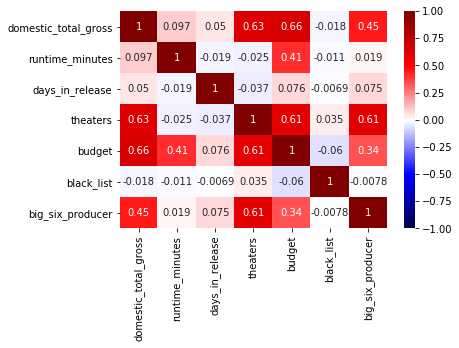

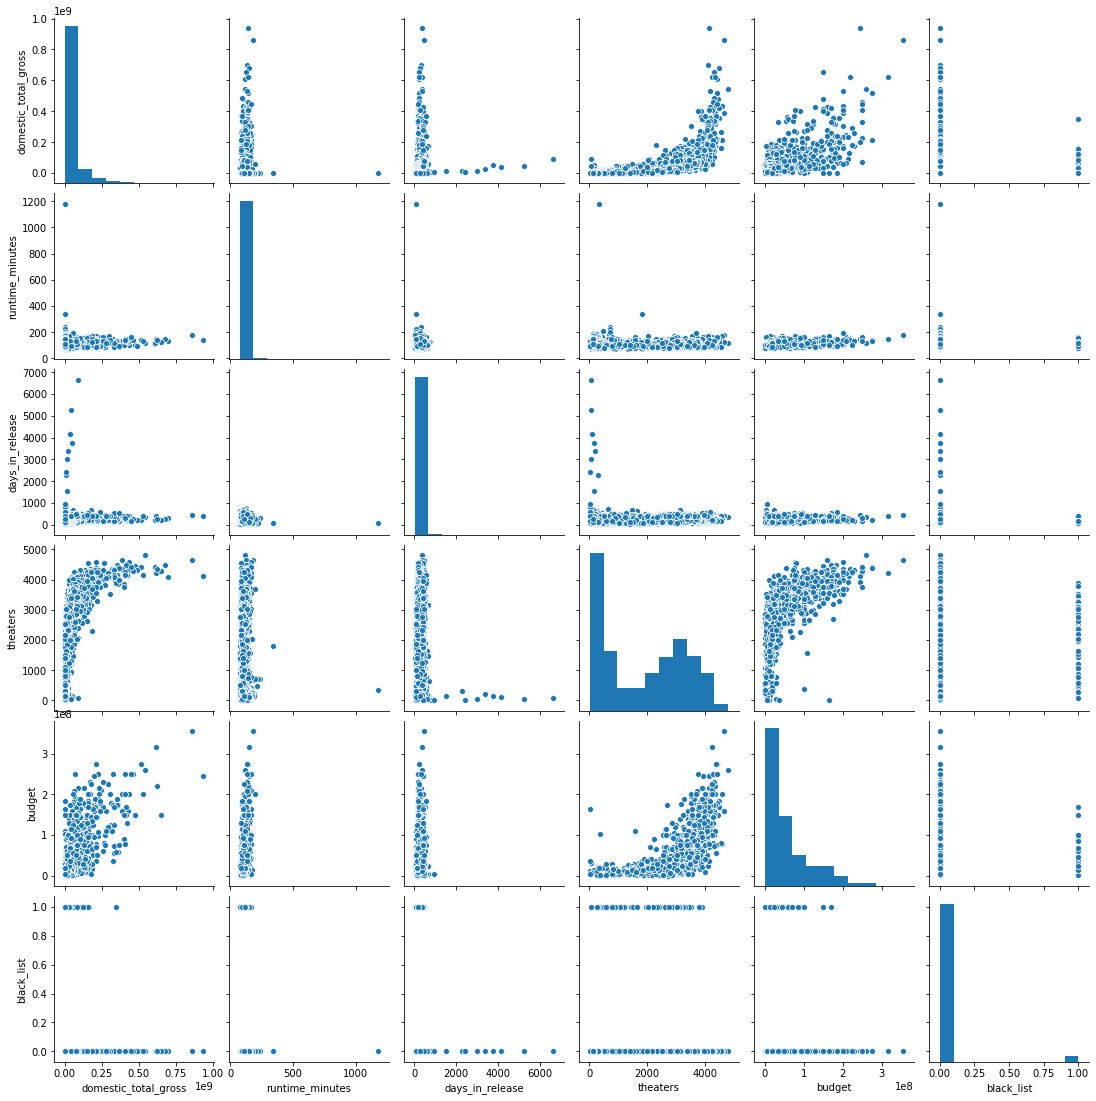

In [54]:
sns.pairplot(movies_df)

In [74]:
movies_df = pd.get_dummies(movies_df,columns=['rating'])

In [75]:
movies_df.head()

,movie_title,domestic_total_gross,runtime_minutes,release_date,genres,days_in_release,theaters,month,budget,opening,black_list,big_six_producer,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R
0,Avengers: Endgame,858373000,181.0,"Apr 26, 2019","['Action', 'Adventure', 'Drama', 'Sci-Fi']",444,4662.0,Apr,356000000.0,Walt Disney Studios,0,1,0,0,0,0,1,0
1,The Lion King,543638043,118.0,"Jul 19, 2019","['Adventure', 'Animation', 'Drama', 'Family', ...",360,4802.0,Jul,260000000.0,Walt Disney Studios,0,1,0,0,0,1,0,0
2,Toy Story 4,434038008,100.0,"Jun 21, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",388,4575.0,Jun,200000000.0,Walt Disney Studios,0,1,1,0,0,0,0,0
3,Frozen II,477373578,103.0,"Nov 22, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",234,4440.0,Nov,150000000.0,Walt Disney Studios,0,1,0,0,0,1,0,0
4,Captain Marvel,426829839,123.0,"Mar 8, 2019","['Action', 'Adventure', 'Sci-Fi']",299,4310.0,Mar,160000000.0,Walt Disney Studios,0,1,0,0,0,0,1,0


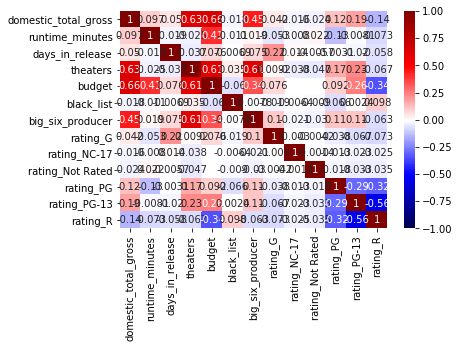

In [76]:
sns.heatmap(movies_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [77]:
movies_df.corr()

,domestic_total_gross,runtime_minutes,days_in_release,theaters,budget,black_list,big_six_producer,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R
domestic_total_gross,1.000000,0.097350,0.049890,0.632255,0.656187,-0.017806,0.446979,0.041897,-0.016307,-0.023674,0.118639,0.187280,-0.142250
runtime_minutes,0.097350,1.000000,-0.019405,-0.025084,0.407644,-0.011198,0.018742,-0.053225,-0.008029,0.022031,-0.132328,-0.008136,-0.072659
days_in_release,0.049890,-0.019405,1.000000,-0.037042,0.076254,-0.006853,0.075242,0.216844,0.014444,-0.005749,-0.003074,-0.020089,-0.058499
theaters,0.632255,-0.025084,-0.037042,1.000000,0.610202,0.034762,0.607064,0.009235,-0.038210,-0.046738,0.171039,0.230095,-0.067118
budget,0.656187,0.407644,0.076254,0.610202,1.000000,-0.059827,0.341381,0.075561,NaN,NaN,0.092023,0.256989,-0.337902
black_list,-0.017806,-0.011198,-0.006853,0.034762,-0.059827,1.000000,-0.007777,-0.018668,-0.006378,-0.009025,-0.066277,0.002389,0.098135
big_six_producer,0.446979,0.018742,0.075242,0.607064,0.341381,-0.007777,1.000000,0.103480,-0.021497,-0.030417,0.112797,0.113939,-0.063448
rating_G,0.041897,-0.053225,0.216844,0.009235,0.075561,-0.018668,0.103480,1.000000,-0.002991,-0.004232,-0.038208,-0.067302,-0.072502
rating_NC-17,-0.016307,-0.008029,0.014444,-0.038210,NaN,-0.006378,-0.021497,-0.002991,1.000000,-0.001446,-0.013055,-0.022996,-0.024773
rating_Not Rated,-0.023674,0.022031,-0.005749,-0.046738,NaN,-0.009025,-0.030417,-0.004232,-0.001446,1.000000,-0.018472,-0.032537,-0.035052


In [86]:
movies_df.head()

,movie_title,domestic_total_gross,runtime_minutes,release_date,genres,days_in_release,theaters,month,budget,opening,black_list,big_six_producer,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R
0,Avengers: Endgame,858373000,181.0,"Apr 26, 2019","['Action', 'Adventure', 'Drama', 'Sci-Fi']",444,4662.0,Apr,356000000.0,Walt Disney Studios,0,1,0,0,0,0,1,0
1,The Lion King,543638043,118.0,"Jul 19, 2019","['Adventure', 'Animation', 'Drama', 'Family', ...",360,4802.0,Jul,260000000.0,Walt Disney Studios,0,1,0,0,0,1,0,0
2,Toy Story 4,434038008,100.0,"Jun 21, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",388,4575.0,Jun,200000000.0,Walt Disney Studios,0,1,1,0,0,0,0,0
3,Frozen II,477373578,103.0,"Nov 22, 2019","['Adventure', 'Animation', 'Comedy', 'Family',...",234,4440.0,Nov,150000000.0,Walt Disney Studios,0,1,0,0,0,1,0,0
4,Captain Marvel,426829839,123.0,"Mar 8, 2019","['Action', 'Adventure', 'Sci-Fi']",299,4310.0,Mar,160000000.0,Walt Disney Studios,0,1,0,0,0,0,1,0


In [116]:
movies_df['domestic_total_gross'].isnull().value_counts()

False    1959
Name: domestic_total_gross, dtype: int64

In [121]:
movies_df = movies_df.fillna(0)

In [119]:
np.where(np.nan_to_num(X))

(array([  0,   0,   1, ..., 998, 999, 999]), array([0, 1, 0, ..., 1, 0, 1]))

In [179]:
lr = LinearRegression()
X = movies_df.iloc[:,[11,12]]
y = movies_df.iloc[:,[1]]
lr.fit(X, y)
lr.score(X,y)


0.19980981773253037

In [180]:
yPrediction = lr.predict(X)


yPrediction.shape

(1959, 1)

In [175]:
X

0       1
1       1
2       1
3       1
4       1
       ..
1954    1
1955    0
1956    0
1957    0
1958    0
Name: big_six_producer, Length: 1959, dtype: int64

In [194]:
movies_df.to_csv('movies.csv')

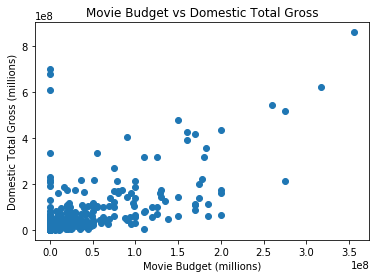

In [189]:
plt.scatter(movies_df.budget[:500],movies_df.domestic_total_gross[:500])
plt.xlabel('Movie Budget (millions)')
plt.ylabel('Domestic Total Gross (millions)')
plt.title('Movie Budget vs Domestic Total Gross')
plt.savefig('Budget_vs_gross')

In [190]:
movies_df.budget.corr(movies_df.domestic_total_gross)

0.6651704947974669

In [192]:
movies_df.domestic_total_gross.corr(movies_df.big_six_producer)

0.446979450915694

In [193]:
movies_df.domestic_total_gross.corr(movies_df.black_list)

-0.017805549978461215